<a href="https://colab.research.google.com/github/LarsHadidi/PRONTO/blob/mathprogram/mp/PDP-AQC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progressive Dinner Party: Adiabatic Quantum Computation

## Hosted Runtime

In [1]:
!pip install -q dwave-ocean-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.4/111.4 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Imports

In [31]:
import dimod
import getpass
import itertools
import numpy as np
import networkx as nx
import ipywidgets as widgets
import matplotlib.pyplot as plt
from dwave.system import LeapHybridCQMSampler 

## Data

In [15]:
w_size = widgets.IntText(description='Size', orientation='horizontal', value=9, min=9)
w_cluster = widgets.IntText(description='Clusters', orientation='horizontal', value=1, min=1)
w_deviation = widgets.FloatText(description='Deviation', orientation='horizontal', value=0.1, min=0)
w_scale = widgets.IntText(description='Scaling', orientation='horizontal', value=1)
display(widgets.Box([w_size, w_cluster,w_deviation, w_scale], layout=widgets.Layout(display='flex', flex_flow='row')))

Box(children=(IntText(value=9, description='Size'), IntText(value=1, description='Clusters'), FloatText(value=…

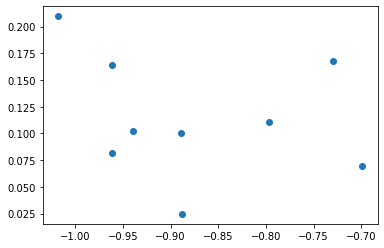

In [18]:
rng = np.random.default_rng()

N = w_size.value
K = w_cluster.value
σ = w_deviation.value
λ = w_scale.value

assert N >= 9
assert K > 0
assert N % K == 0
assert N % 3 == 0
assert σ >= 0
assert λ > 0

points = {}
centers = rng.uniform(-1, 1, (K, 2))
for i in range(K):
	points[str(centers[i])] = λ * rng.normal(centers[i], σ, (N // K, 2))

X = np.array(list(points.values())).reshape(N, 2)[:,0]
Y = np.array(list(points.values())).reshape(N, 2)[:,1]

G = nx.DiGraph()
for i in range(N):
	G.add_node(i, x = X[i], y = Y[i])

C = np.empty((N,N))
for a,b in itertools.product(range(N), range(N)):
	dX = (X[b]-X[a]) * (X[b]-X[a])
	dY = (Y[b]-Y[a]) * (Y[b]-Y[a])
	C[a,b] = np.sqrt(dX + dY)

plt.scatter(X,Y)
plt.show()

## Draft

In [26]:
cqm = dimod.ConstrainedQuadraticModel()

In [27]:
N = 9

e = [[dimod.Binary(f'e_{i}_{j}') for j in range(N)] for i in range(N)]
s = [dimod.Binary(f's_{i}') for i in range(N)]
m = [dimod.Binary(f'm_{i}') for i in range(N)]
d = [dimod.Binary(f'd_{i}') for i in range(N)]

cqm.set_objective(dimod.quicksum(C[i,j] * e[i][j] for i,j in itertools.product(range(N), range(N))))

for i in range(N):
  cqm.add_constraint(s[i] + m[i] + d[i] == 1)
  
  cqm.add_constraint(dimod.quicksum( s[i] * e[j][i] for j in range(N) ) == 0)
  cqm.add_constraint(dimod.quicksum( s[i] * e[i][j] for j in range(N) ) - 3 * s[i] == 0)

  cqm.add_constraint(dimod.quicksum( m[i] * e[j][i] for j in range(N) ) - 3 * m[i] == 0)
  cqm.add_constraint(dimod.quicksum( m[i] * e[i][j] for j in range(N) ) - 3 * m[i] == 0)

  cqm.add_constraint(dimod.quicksum( d[i] * e[j][i] for j in range(N) ) - 3 * d[i] == 0)
  cqm.add_constraint(dimod.quicksum( d[i] * e[i][j] for j in range(N) ) == 0)

  cqm.add_constraint(dimod.quicksum(m) * 3 == N)

for i,j in itertools.product(range(N), range(N)):
  cqm.add_constraint(s[i] * e[i][j] + d[j] <= 1)

In [34]:
sampler = LeapHybridCQMSampler(token=getpass.getpass())
sampleset = sampler.sample_cqm(cqm, label="PDP Optimization")
print(sampleset)

··········
   d_0 d_1 d_2 d_3 d_4 d_5 d_6 d_7 d_8 e_0_0 e_0_1 ... s_8   energy num_oc. ...
10 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0   0.0   0.0 ... 0.0 0.718107       1 ...
67 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0   0.0   0.0 ... 0.0 1.195938       1 ...
15 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0   0.0   0.0 ... 0.0 1.727093       1 ...
68 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0   0.0   0.0 ... 0.0  1.73892       1 ...
69 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   0.0   0.0 ... 0.0 1.979577       1 ...
70 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0   0.0   0.0 ... 0.0 2.163351       1 ...
7  0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0   0.0   0.0 ... 1.0 2.191805       1 ...
71 0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0 0.0   1.0   0.0 ... 0.0 2.210831       1 ...
72 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 1.0   0.0   1.0 ... 0.0 2.218309       1 ...
73 0.0 1.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0   0.0   0.0 ... 0.0 2.319349       1 ...
20 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0   1.0   1.0 ... 0.0 2.332469       1 ...
74 0.0 0.0 0.0 1.0 0.0 1.0 0.